# Data preparation & data loaders
Split data and create DataLoader objects.
Contains:
- Train-validation-test split logic
- Transform/augmentation definitions
- DataLoader creation for each split (with appropriate batch sizes, shuffling)

## Data transform & augmentation

In [1]:
from torchvision import transforms
import torchaudio.transforms as T

# for CHECK
from PIL import Image
import pandas as pd

### Test code

In [3]:
# chain multiple image transforms together into one pipeline
train_transform_test = transforms.Compose([
    # SpecAugment: Freq Masking (DOMAIN-SPECIFIC): Masks random frequency bands (horiz bars) (up to N freq bins) 
    #T.FrequencyMasking(freq_mask_param=15),
    # SpecAugment: Time Masking (DOMAIN-SPECIFIC): Masks random time segments (vert bars) (up to N time frames)
    #T.TimeMasking(time_mask_param=25),
    
    # ColorJitter: Brightness, Contrast, Saturation, Hue (N% of variation)
    # transforms.ColorJitter(brightness=0.2),
    # transforms.ColorJitter(contrast=0.2),
    # transforms.ColorJitter(saturation=0.2),
    # transforms.ColorJitter(hue=0.1),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Random Grayscale (with N% probability)
    # transforms.RandomGrayscale(p=0.3),
    # PIL Image (H×W×C, values 0-255) → PyTorch tensor (C×H×W, values 0.0-1.0)
    transforms.ToTensor(),
    # standardizes pixel values by formula 'normalized_value=(pixel_value-mean)/std' for each color channel (R,G,B)
    transforms.Normalize(mean=[0.2, 0.1, 0.3], std=[0.2, 0.1, 0.2])
])

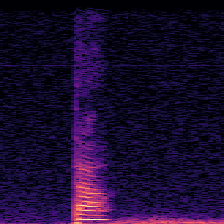

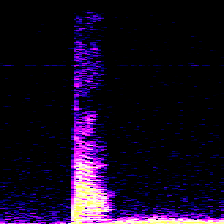

In [4]:
# CHECK whether and how transform and augmentation work
# (I checked all augmentation methods one by one and selected only relevant)

# load image
df = pd.read_csv('/Users/hela/Code/pata/data_labeled.csv')
initial_image = Image.open(df.iloc[1476]['image_path']).convert('RGB')
# transform (tensor)
transformed_image = train_transform_test(initial_image)
# Convert tensor back to PIL for display
final_image = transforms.ToPILImage()(transformed_image.clamp(0, 1))

display(initial_image)
display(final_image)

#### Calculate stats for normalization

In [ ]:
from tqdm import tqdm

def calculate_dataset_stats():
    df = pd.read_csv('/Users/hela/Code/pata/data_labeled.csv')
    transform = transforms.Compose([transforms.ToTensor()])
    pixel_sum = [0.0, 0.0, 0.0]  # Sum of all pixel values [R, G, B]
    pixel_sq_sum = [0.0, 0.0, 0.0]  # Sum of squared pixel values
    num_pixels = 0  # Total number of pixels processed
    for idx in tqdm(range(len(df))):
        # Load and transform image
        image = transform(Image.open(df.iloc[idx]['image_path']).convert('RGB'))
        # Calculate sums for each channel
        for channel in range(3):
            channel_data = image[channel, :, :]  # Get one channel
            pixel_sum[channel] += channel_data.sum().item()
            pixel_sq_sum[channel] += (channel_data ** 2).sum().item()
        num_pixels += 224*224
    # Calculate mean
    mean = [pixel_sum[i] / num_pixels for i in range(3)]
    # Calculate std using: std = sqrt(E[X^2] - E[X]^2)
    std = [((pixel_sq_sum[i] / num_pixels) - (mean[i] ** 2)) ** 0.5 for i in range(3)]
    return mean, std

In [ ]:
mean, std = calculate_dataset_stats()
print(f'mean={mean} \n std={std}')

### FInal code

In [4]:
def get_transforms():
    # Training transforms
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        # PIL Image (H×W×C, values 0-255) → PyTorch tensor (C×H×W, values 0.0-1.0)
        transforms.ToTensor(),
        # standardizes pixel values by formula 'normalized_value=(pixel_value-mean)/std' for each color channel (R,G,B)
        transforms.Normalize(mean=[0.2, 0.1, 0.3], std=[0.2, 0.1, 0.2]),
        # ColorJitter: Brightness, Contrast, Saturation, Hue (N% of variation)
        # transforms.ColorJitter(brightness=0.2),
        # transforms.ColorJitter(contrast=0.2),
        # transforms.ColorJitter(saturation=0.2),
        # transforms.ColorJitter(hue=0.1),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        # Random Grayscale (with N% probability)
        # transforms.RandomGrayscale(p=0.3),
    ])

    # Validation transforms
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.2, 0.1, 0.3], std=[0.2, 0.1, 0.2])
    ])

    return train_transform, val_transform

In [5]:
# CHECK

train_transform, val_transform = get_transforms()
train_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.2, 0.1, 0.3], std=[0.2, 0.1, 0.2])
)

## Data loaders (train & valid sets)

In [18]:
from torch.utils.data import random_split, DataLoader
import torch

# for check
import import_ipynb
import pytorch_model_01_dataset_class

### Test code

In [ ]:
def prepare_data_loaders_test():
    # get transforms
    train_transform, val_transform = get_transforms()
    return train_transform, val_transform

train_transform, val_transform = prepare_data_loaders_test()
train_transform

In [ ]:
def prepare_data_loaders_test():
    # create full ds
    full_ds = pytorch_model_01_dataset_class.DS()
    label_to_idx = full_ds.label_to_idx
    return full_ds, label_to_idx

full_ds, label_to_idx = prepare_data_loaders_test()
label_to_idx

In [5]:
def prepare_data_loaders_test(val_split=0.2):
    # split into train and validation
    full_ds = pytorch_model_01_dataset_class.DS()
    val_size = int(val_split * len(full_ds))
    train_size = len(full_ds) - val_size
    train_ds, val_ds = random_split(full_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    return train_ds, val_ds, val_size, train_size

train_ds, val_ds, val_size, train_size = prepare_data_loaders_test()
train_size

Dataset initialized with: 1600 samples
Label mapping: {'pa': 0, 'ta': 1}
Class distribution:
label
pa    800
ta    800
Name: count, dtype: int64


1280

In [15]:
def prepare_data_loaders_test(val_split=0.2):
    # create full ds
    full_ds = pytorch_model_01_dataset_class.DS()
    label_to_idx = full_ds.label_to_idx
    # split into train and validation
    val_size = int(val_split * len(full_ds))
    train_size = len(full_ds) - val_size
    train_ds, val_ds = random_split(full_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    # Dataset transform
    train_transform, val_transform = get_transforms()
    train_ds.dataset.transform = train_transform
    val_ds.dataset.transform = val_transform
    print(f'\nDataset splits (val_split={val_split}):')
    print(f'Training set: {train_size}')
    print(f'Validation set: {val_size}')
    return train_ds, val_ds

train_ds, val_ds = prepare_data_loaders_test()
train_ds

Dataset initialized with: 1600 samples
Label mapping: {'pa': 0, 'ta': 1}
Class distribution:
label
pa    800
ta    800
Name: count, dtype: int64

Dataset splits:
Training set: 1280
Validation set: 320


In [20]:
def prepare_data_loaders_test(val_split=0.2, batch_size=32):
    
    # create full ds
    full_ds = pytorch_model_01_dataset_class.DS()
    label_to_idx = full_ds.label_to_idx
    
    # split into train and validation
    val_size = int(val_split * len(full_ds))
    train_size = len(full_ds) - val_size
    train_ds, val_ds = random_split(full_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    
    # dataset transform
    train_transform, val_transform = get_transforms()
    train_ds.dataset.transform = train_transform
    val_ds.dataset.transform = val_transform

    # create data loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

train_loader, val_loader = prepare_data_loaders_test()
train_loader

Dataset initialized with: 1600 samples
Label mapping: {'pa': 0, 'ta': 1}
Class distribution:
label
pa    800
ta    800
Name: count, dtype: int64


### Final code

In [27]:
def prepare_data_loaders(val_split=0.2, batch_size=32):
    
    # create full ds
    full_ds = pytorch_model_01_dataset_class.DS()
    label_to_idx = full_ds.label_to_idx
    
    # split into train and validation
    val_size = int(val_split * len(full_ds))
    train_size = len(full_ds) - val_size
    train_ds, val_ds = random_split(full_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    print(f'\nDataset splits (val_split={val_split}):')
    print(f'Training set: {train_size}')
    print(f'Validation set: {val_size}')
    
    # dataset transform
    train_transform, val_transform = get_transforms()
    train_ds.dataset.transform = train_transform
    val_ds.dataset.transform = val_transform

    # create data loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [28]:
train_loader, val_loader = prepare_data_loaders()
train_loader

Dataset initialized with: 1600 samples
Label mapping: {'pa': 0, 'ta': 1}
Class distribution:
label
pa    800
ta    800
Name: count, dtype: int64

Dataset splits (val_split=0.2):
Training set: 1280
Validation set: 320
